# Final Project - Detecting Fraudulent Credit Card Transactions

| Course | Term | Section | Group | Objective | Kaggle URL |
| --- | --- | --- | --- | --- | --- |
| W207 | Fall 2022 | 11 | 2 | Detect fraudulent credit card transactions | IEEE-CIS Fraud Detection ([Link](kaggle.com/competitions/ieee-fraud-detection)) |

### Group Members 
- Naikaj Pandya
- Chase Madson
- Eric Danforth


# I. Setup

## Import Packages

In [1]:
# Import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
from math import floor
# sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


# import tensorflow as tf
# from tensorflow import keras
# from keras import metrics
# tf.get_logger().setLevel('INFO')

## Load Data

In [2]:
train_identity = pd.read_csv('data/train_identity.csv')
train_transaction = pd.read_csv('data/train_transaction.csv')
test_identity = pd.read_csv('data/test_identity.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')
sub = pd.read_csv('data/sample_submission.csv')
# let's combine the data and work with the whole dataset
#train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
#test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# II. EDA

In [3]:
tmp_dict = {
 name:{
    'Transactions': len(df), 
    'Features': len(df.columns),
    'Features w/ Nulls': df.isnull().any().sum(),
    'Date Range': [floor(i / (60 * 60 * 24)) - 1 for i in (df['TransactionDT'].min(), df['TransactionDT'].max())] 
                  if 'TransactionDT' in df else '',
    'Percent Fraudulent': str(round(100 * df.isFraud.sum() / len(df), 3)) + '%'
                          if 'isFraud' in df else '',
    }
 for df, name
 in zip(
   (train_transaction, test_transaction, train_identity, test_identity),
   ('train_transaction', 'test_transaction', 'train_identity', 'test_identity')
   )
}

pd.DataFrame.from_dict(tmp_dict, dtype='str')

,train_transaction,test_transaction,train_identity,test_identity
Transactions,590540,506691,144233,141907
Features,394,393,41,41
Features w/ Nulls,374,345,38,38
Date Range,"[0, 181]","[212, 394]",,
Percent Fraudulent,3.499%,,,


## Transaction Amount

(-0.5, 1.5, 0.0, 400.0)

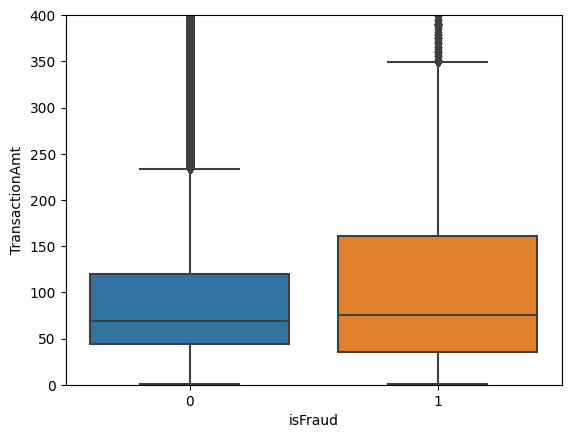

In [9]:
sns.boxplot(data=train_transaction, x='isFraud', y='TransactionAmt').axis(ymin=0,ymax=400)

## Look at an Example of Fraud

In [54]:
tmp_fraud_id = train_transaction[train_transaction['isFraud'] == 1].TransactionID.sample(1).values[0]
train_transaction[
    train_transaction['TransactionID'] == tmp_fraud_id
    ]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
422139,3409139,1,10692800,207.95,W,7664,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
train_identity[train_identity['TransactionID'] == tmp_fraud_id]

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo


In [56]:
train_transaction[train_transaction['card1'] == 16075]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
138,2987138,0,88725,100.000,H,16075,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224,2987224,0,89966,67.950,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,2987481,0,94555,109.000,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552,2987552,0,96068,80.000,H,16075,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
735,2987735,0,100559,150.000,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589151,3576151,0,15783224,81.917,C,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
589153,3576153,0,15783297,81.917,C,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
589350,3576350,0,15787033,59.000,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590496,3577496,0,15810229,349.620,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# III. Training a Model

## Baseline Model with KNN

In [57]:
# split the data into training and test sets

tmp = (
    # One-hot encode the desired variables, leaving one value out as default
    pd.get_dummies(train_transaction, columns=['ProductCD', 'card4'], prefix=['ProductCD_', 'card4_'])
    .merge(train_identity.iloc[:,range(2)], on='TransactionID', how='left')
    .assign(have_identity=lambda df: ~pd.isna(df['id_01']))
    .loc[:,['isFraud', 'TransactionDT', 'TransactionAmt', 'card4__discover', 'card4__mastercard', 'card4__visa',
            'ProductCD__H', 'ProductCD__R', 'ProductCD__S', 'ProductCD__W',
            'C1', 'C2', 'C3', 'C4', 'C5', 'have_identity', 'id_01']]
    .dropna()
    )

X = tmp.loc[:, tmp.columns != 'isFraud']
y = tmp['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

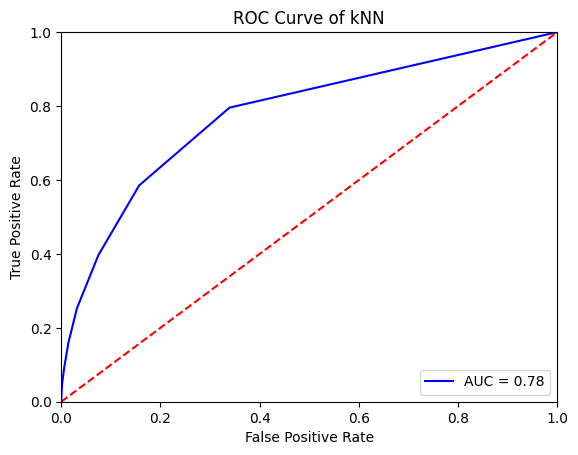

In [58]:
knn = KNeighborsClassifier(n_neighbors = 10)

knn.fit(X_train, y_train)

y_scores = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()